In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2023-05-19 16:42:24.741670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 16:42:26.409239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(train_images, _) , (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-05-19 16:42:29.262896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 16:42:29.408853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 16:42:29.409171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

2023-05-19 16:42:32.610333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-19 16:42:34.514645: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


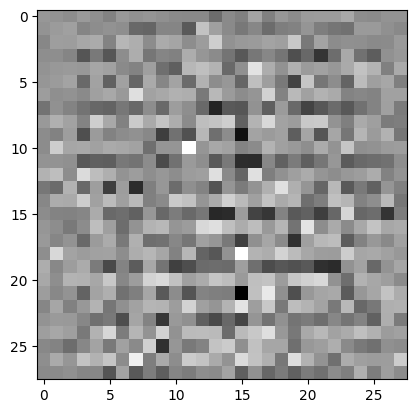

In [6]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00082097]], shape=(1, 1), dtype=float32)


In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
import time

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

In [13]:
train(train_dataset, EPOCHS)

2023-05-19 16:42:35.503461: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-05-19 16:42:35.742418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2023-05-19 16:42:35.742730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2023-05-19 16:42:37.910459: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match si

Time for epoch 1 is 37.14697575569153 sec
Time for epoch 2 is 29.134690761566162 sec
Time for epoch 3 is 28.786275625228882 sec
Time for epoch 4 is 29.200124979019165 sec
Time for epoch 5 is 29.26278781890869 sec
Time for epoch 6 is 29.030155658721924 sec
Time for epoch 7 is 29.6195068359375 sec
Time for epoch 8 is 31.269718170166016 sec
Time for epoch 9 is 31.16012930870056 sec
Time for epoch 10 is 30.515366792678833 sec
Time for epoch 11 is 30.583882093429565 sec
Time for epoch 12 is 28.267143964767456 sec
Time for epoch 13 is 28.88731360435486 sec
Time for epoch 14 is 28.90593671798706 sec
Time for epoch 15 is 28.87155771255493 sec
Time for epoch 16 is 29.23453140258789 sec
Time for epoch 17 is 29.20535159111023 sec
Time for epoch 18 is 28.95000147819519 sec
Time for epoch 19 is 28.919780254364014 sec
Time for epoch 20 is 29.073426246643066 sec
Time for epoch 21 is 28.984980821609497 sec
Time for epoch 22 is 29.022863626480103 sec
Time for epoch 23 is 29.01695680618286 sec
Time for 

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

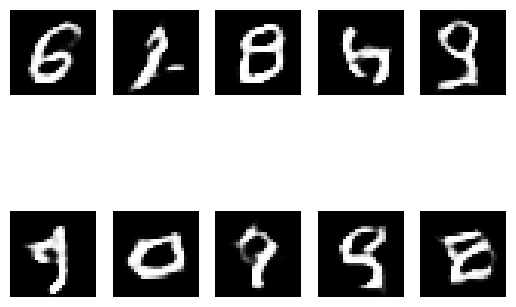

In [45]:
# generate and plot 10 images
noise = tf.random.normal([10, 100])
generated_images = generator(noise, training=False)
decision = discriminator(generated_images)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')